In [1]:
from matplotlib import *
from __future__ import division
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.cm as cm

(6.031933357009618, 19.115069610626982, 34.9129060439669, 47.671730303723834)

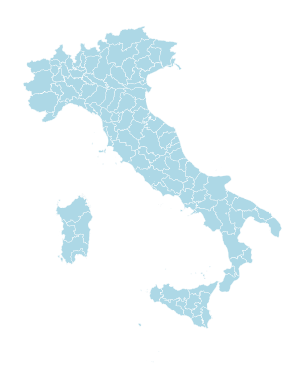

In [2]:
map_prov = gpd.read_file('../data/georef-italy-provincia/georef-italy-provincia-millesime.shp')
map_prov = map_prov[['prov_sigla','geometry']]
map_prov.prov_sigla.unique().size
map_prov.plot(edgecolor='w',facecolor='lightblue',lw=.2)
plt.axis('off')

In [3]:
from scipy.integrate import solve_ivp

In [4]:
# set the seeding city
seed = 0
nseeds = 10

# Parameters
num_patches = 1 # Number of patches
beta = 0.7     # Infection rate
gamma = 0.2      # Recovery rate (5 days inf period)
population = 400  # Total population per patch

# Time span for simulation
t_max = 200
t_span = (0, t_max)
t_eval = np.linspace(0, t_max-1, t_max)
dt = t_eval[1]-t_eval[0]

# Force of infection function
def force_of_infection(beta, I, N):
    return beta * I / N 

# Initial conditions (S, I, R for each patch)
S0 = np.linspace(population,population, num_patches)# initial susceptible populations
S0[seed] -= nseeds   # remove seeds from seed susceptible populations

I0 = np.zeros(num_patches) # initial infected populations
I0[seed] = nseeds          # seeds

R0 = np.zeros(num_patches) # initial recovered populations


# Model system of ODEs
def sir_model(t, y, beta, gamma, population):
    # Reshape the state vector y into S, I, R for each patch
    S = y[:num_patches] #top rows
    I = y[num_patches:2*num_patches] #middle rows
    R = y[3*num_patches:] #bottom rows
    
    # Calculate the force of infection for each patch
    N = np.array([population] * num_patches)
    lambda_i = force_of_infection(beta, I, N)
    
    # Compute the derivatives for each patch
    dSdt = - S * lambda_i 
    dIdt = (S * lambda_i)  - (gamma * I)
    dRdt = gamma * I 

    # Concatenate the derivatives into a single vector
    return np.concatenate([dSdt, dIdt, dRdt])

# Initial state vector
y0 = np.concatenate([S0, I0, R0]) #top rows = S, second rows = I, bottom rows = R

# Solve the system of ODEs
solution = solve_ivp(sir_model, t_span, y0, args=(beta, gamma, population), t_eval=t_eval)

# Extract results
S, I, R = solution.y[:num_patches], solution.y[num_patches:2*num_patches], solution.y[2*num_patches:3*num_patches]



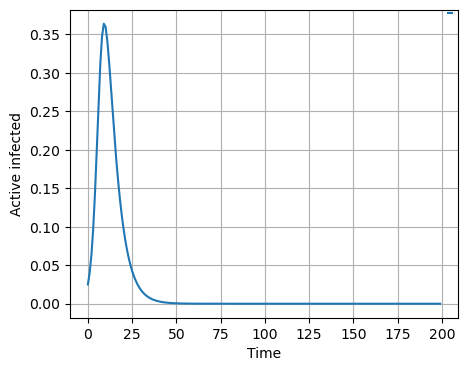

In [6]:
# Plot the results
plt.figure(figsize=(5, 4))

# Plot Susceptible, Infected, and Recovered over time
for i in range(num_patches):
    plt.plot(solution.t, I[i]/population, label=f'I ')

plt.xlabel('Time')
plt.ylabel('Active infected')
plt.legend(frameon=False, fontsize=1.7)
plt.grid(True)
plt.show()

In [7]:
import numpy as np
import pymc as pm
#import aesara.tensor as at
import arviz as az
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.cm as cm
from scipy.stats import gamma

In [8]:
# Constants
T = 20 #n of weeks
Tf = 8 #n of weeks with data
M = 1 #n of regions in which you have data

a = 1.4
b = 2

# True values for simulation
Rh_true = 1.38 
Rv_true = 2.1 

rh_true = (Rh_true**(1/a) - 1) * b 
rv_true = (Rv_true**(1/a) - 1) * b 

# Data on first weeks prevalence of invading variant
p0_true = np.random.uniform(0, 0.01, size=M)

# Time matrix
time = np.arange(1, T + 1)
t_matrix = np.tile(time, (M, 1))  # shape (M, T)

# Simulate the variant growth in prevalence with the logistic growth function
logit_init = ((1 - p0_true) / p0_true)[:, np.newaxis]
growth_diff = (rh_true - rv_true) * t_matrix * 7
p_true = 1 / (1 + logit_init * np.exp(growth_diff))  # shape (M, T)

# Simulate observed data, number of sequenced tests "casN" and positive to new variants "casP"
casN = np.random.randint(400, 1000, size=(M, Tf))
casP = np.random.binomial(n=casN, p=p_true[:, :Tf])

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Rv, p0]


Output()

Sampling 4 chains for 500 tune and 1_000 draw iterations (2_000 + 4_000 draws total) took 1 seconds.


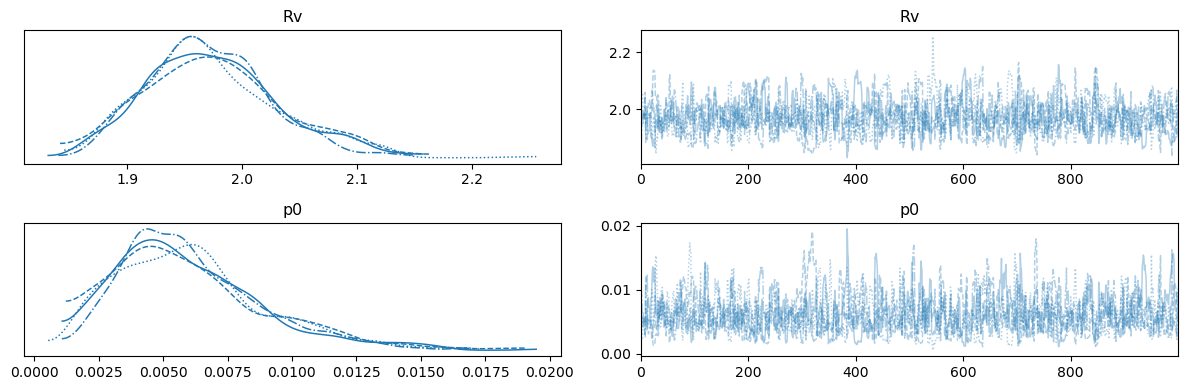

       mean    sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
Rv     1.97  0.06    1.88     2.09        0.0      0.0    591.93    679.44   
p0[0]  0.01  0.00    0.00     0.01        0.0      0.0    577.81    682.13   

       r_hat  
Rv      1.00  
p0[0]   1.01  


In [9]:


# --------------------------
# PyMC Model (v5.23.0)
# --------------------------

with pm.Model() as model:

    # Global reproduction numbers with Gamma priors
    Rv = pm.Gamma("Rv", alpha=2, beta=1)  # R0 for Omicron

    # Convert to growth rates
    rv = pm.Deterministic("rv", ( Rv**(1/a) - 1) * b )

    # Initial Omicron proportions (p0), inferred per region
    p0 = pm.Exponential("p0", lam=3, shape=M)

    # Time matrix
    t_vals = np.arange(1, T + 1)
    t_matrix = np.tile(t_vals, (M, 1))  # shape (M, T)

    # Logistic growth computation
    logit_init = ((1 - p0) / p0).dimshuffle(0, 'x')  # shape (M, 1)
    growth_diff = (rh_true - rv) * t_matrix * 7
    p = pm.Deterministic("p", 1 / (1 + logit_init * np.exp(growth_diff)))

    # Likelihood
    casP_obs = pm.Binomial("casP_obs", n=casN, p=p[:, :Tf], observed=casP)

    # Sampling
    trace = pm.sample(draws=1000, tune=500, discard_tuned_samples=True, chains=4, target_accept=0.95, random_seed=42)

# --------------------------
# Results
# --------------------------

az.plot_trace(trace, var_names=["Rv", "p0"])
plt.tight_layout()
plt.show()

print(az.summary(trace, var_names=["Rv", "p0"], round_to=2))
